# Train and test the model

In [2]:
from preprocessor import Preprocessor
import batch_generator
from keras.optimizers import Adam
import modelling
import importlib
import evaluating
from keras.models import Model
import numpy as np

In [3]:
importlib.reload(batch_generator)

<module 'batch_generator' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\batch_generator.py'>

In [4]:
train_generator = batch_generator.BatchGenerator(64, 64, mode='train')
test_generator = batch_generator.BatchGenerator(64, 64, mode='test')

In [6]:
shapes = train_generator[0]
shapes[0][0].shape, shapes[0][1].shape, shapes[1].shape

((128, 30), (128, 28), (128, 1))

In [78]:
importlib.reload(modelling)

<module 'modelling' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\modelling.py'>

### Content model

In [51]:
content_model = modelling.ContentModel(
    30, 23, [42, 102], [2, 2],
    28, 23, [42, 102, 102], [2, 2, 2],
    20, 10,
)

In [55]:
content_model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
content_model.fit_generator(train_generator, epochs=1)
content_model.evaluate_generator(test_generator)

Epoch 1/1


436/695 [=================>............] - ETA: 8:22 - loss: 0.4596 - acc: 0.781 - ETA: 1:49 - loss: 0.5329 - acc: 0.743 - ETA: 1:12 - loss: 0.5300 - acc: 0.750 - ETA: 56s - loss: 0.5508 - acc: 0.734 - ETA: 46s - loss: 0.5342 - acc: 0.74 - ETA: 40s - loss: 0.5366 - acc: 0.73 - ETA: 35s - loss: 0.5381 - acc: 0.73 - ETA: 33s - loss: 0.5425 - acc: 0.73 - ETA: 32s - loss: 0.5466 - acc: 0.73 - ETA: 31s - loss: 0.5439 - acc: 0.73 - ETA: 30s - loss: 0.5372 - acc: 0.73 - ETA: 30s - loss: 0.5325 - acc: 0.74 - ETA: 29s - loss: 0.5336 - acc: 0.74 - ETA: 28s - loss: 0.5297 - acc: 0.74 - ETA: 28s - loss: 0.5285 - acc: 0.74 - ETA: 27s - loss: 0.5257 - acc: 0.75 - ETA: 27s - loss: 0.5271 - acc: 0.74 - ETA: 27s - loss: 0.5262 - acc: 0.74 - ETA: 26s - loss: 0.5256 - acc: 0.75 - ETA: 26s - loss: 0.5256 - acc: 0.74 - ETA: 26s - loss: 0.5279 - acc: 0.74 - ETA: 25s - loss: 0.5253 - acc: 0.74 - ETA: 25s - loss: 0.5245 - acc: 0.75 - ETA: 25s - loss: 0.5227 - acc: 0.75 - ETA: 25s - loss: 0.5224 - acc: 0.75 - 

695/695 [==============================] - ETA: 8s - loss: 0.4933 - acc: 0.769 - ETA: 8s - loss: 0.4932 - acc: 0.769 - ETA: 8s - loss: 0.4927 - acc: 0.769 - ETA: 8s - loss: 0.4927 - acc: 0.769 - ETA: 8s - loss: 0.4924 - acc: 0.769 - ETA: 8s - loss: 0.4921 - acc: 0.769 - ETA: 8s - loss: 0.4919 - acc: 0.770 - ETA: 8s - loss: 0.4919 - acc: 0.770 - ETA: 8s - loss: 0.4918 - acc: 0.770 - ETA: 8s - loss: 0.4915 - acc: 0.770 - ETA: 8s - loss: 0.4915 - acc: 0.770 - ETA: 8s - loss: 0.4916 - acc: 0.770 - ETA: 8s - loss: 0.4916 - acc: 0.770 - ETA: 7s - loss: 0.4915 - acc: 0.770 - ETA: 7s - loss: 0.4915 - acc: 0.770 - ETA: 7s - loss: 0.4914 - acc: 0.770 - ETA: 7s - loss: 0.4912 - acc: 0.770 - ETA: 7s - loss: 0.4915 - acc: 0.770 - ETA: 7s - loss: 0.4915 - acc: 0.770 - ETA: 7s - loss: 0.4914 - acc: 0.770 - ETA: 7s - loss: 0.4916 - acc: 0.770 - ETA: 7s - loss: 0.4916 - acc: 0.770 - ETA: 7s - loss: 0.4922 - acc: 0.770 - ETA: 7s - loss: 0.4923 - acc: 0.769 - ETA: 7s - loss: 0.4921 - acc: 0.769 - ETA: 7s

[0.5485676192207101, 0.7308063271604939]

### Time model

In [57]:
time_model = modelling.TimeModel(30, 23, 28, 23, 5, 3)

In [60]:
time_model.compile(Adam(lr=.001), loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
time_model.fit_generator(train_generator, epochs=1)
time_model.evaluate_generator(test_generator)

Epoch 1/1


438/695 [=================>............] - ETA: 7:38 - loss: 0.1650 - acc: 0.960 - ETA: 1:22 - loss: 0.3257 - acc: 0.867 - ETA: 48s - loss: 0.3142 - acc: 0.875 - ETA: 40s - loss: 0.3086 - acc: 0.87 - ETA: 33s - loss: 0.3045 - acc: 0.87 - ETA: 32s - loss: 0.3134 - acc: 0.87 - ETA: 31s - loss: 0.3161 - acc: 0.87 - ETA: 30s - loss: 0.3200 - acc: 0.87 - ETA: 29s - loss: 0.3139 - acc: 0.87 - ETA: 29s - loss: 0.3146 - acc: 0.87 - ETA: 28s - loss: 0.3171 - acc: 0.86 - ETA: 27s - loss: 0.3178 - acc: 0.86 - ETA: 27s - loss: 0.3191 - acc: 0.86 - ETA: 26s - loss: 0.3197 - acc: 0.86 - ETA: 26s - loss: 0.3228 - acc: 0.86 - ETA: 25s - loss: 0.3244 - acc: 0.86 - ETA: 25s - loss: 0.3283 - acc: 0.86 - ETA: 25s - loss: 0.3266 - acc: 0.86 - ETA: 25s - loss: 0.3284 - acc: 0.86 - ETA: 24s - loss: 0.3288 - acc: 0.86 - ETA: 24s - loss: 0.3261 - acc: 0.86 - ETA: 24s - loss: 0.3285 - acc: 0.86 - ETA: 24s - loss: 0.3283 - acc: 0.86 - ETA: 23s - loss: 0.3266 - acc: 0.86 - ETA: 23s - loss: 0.3280 - acc: 0.86 - ET

695/695 [==============================] - ETA: 8s - loss: 0.3067 - acc: 0.871 - ETA: 8s - loss: 0.3069 - acc: 0.871 - ETA: 8s - loss: 0.3066 - acc: 0.871 - ETA: 8s - loss: 0.3067 - acc: 0.871 - ETA: 8s - loss: 0.3067 - acc: 0.871 - ETA: 8s - loss: 0.3066 - acc: 0.871 - ETA: 8s - loss: 0.3067 - acc: 0.871 - ETA: 8s - loss: 0.3069 - acc: 0.871 - ETA: 7s - loss: 0.3072 - acc: 0.871 - ETA: 7s - loss: 0.3071 - acc: 0.871 - ETA: 7s - loss: 0.3069 - acc: 0.871 - ETA: 7s - loss: 0.3067 - acc: 0.871 - ETA: 7s - loss: 0.3067 - acc: 0.871 - ETA: 7s - loss: 0.3067 - acc: 0.871 - ETA: 7s - loss: 0.3067 - acc: 0.871 - ETA: 7s - loss: 0.3068 - acc: 0.871 - ETA: 7s - loss: 0.3066 - acc: 0.871 - ETA: 7s - loss: 0.3064 - acc: 0.872 - ETA: 7s - loss: 0.3062 - acc: 0.872 - ETA: 7s - loss: 0.3059 - acc: 0.872 - ETA: 7s - loss: 0.3059 - acc: 0.872 - ETA: 7s - loss: 0.3060 - acc: 0.872 - ETA: 6s - loss: 0.3059 - acc: 0.872 - ETA: 6s - loss: 0.3057 - acc: 0.872 - ETA: 6s - loss: 0.3057 - acc: 0.872 - ETA: 6s

[0.22708669967121548, 0.9054783950617284]

### Single model

In [92]:
importlib.reload(modelling)

<module 'modelling' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\modelling.py'>

In [ ]:
# single_model = modelling.SingleModel(content_model, time_model, 30, 28)

In [110]:
preds = []
true = []
for batch in train_batch_generator:
    content_score = content_model.predict(batch[0])
    time_score = time_model.predict(batch[0])
    pred = 2 * content_score * time_score / (content_score + time_score)
    
    preds.append(pred)
    true.append(batch[1])

In [111]:
pred = np.vstack(preds)
true = np.vstack(true)

In [112]:
pred.shape, true.shape

((88064, 1), (88064, 1))

In [143]:
score = ((pred >= 0.5) == true)

In [144]:
score.mean()

0.8776458030523255

---

# Compute feature importance

In [32]:
# fn for content model
fn_content = {
    "que": [
        'students_state',
        'students_location',

        'questions_body_length',

#         'students_average_question_body_length',
#         'students_average_answer_body_length',
    ],
    
    "pro": [
        'professionals_state',
        'professionals_location',
        'professionals_industry',

#         'professionals_average_question_body_length',
#         'professionals_average_answer_body_length',
    ]
}

fn_time = {
    "que": [
#         'students_questions_asked',
#         'students_average_question_age',

        'students_date_joined_time',
        'students_date_joined_doy_sin',
        'students_date_joined_doy_cos',

        'questions_date_added_time',
        'questions_date_added_doy_sin',
        'questions_date_added_doy_cos',

        'questions_current_time',
    ],
    
    "pro": [
#         'professionals_questions_answered',
#         'professionals_average_question_age',
#         'professionals_email_activated',

        'professionals_date_joined_time',
        'professionals_date_joined_doy_sin',
        'professionals_date_joined_doy_cos',

        'professionals_previous_answer_date_time',
        'professionals_current_time'
    ]
}

In [33]:
fn_content['que'] += [f'que_emb_{i}' for i in range(10)]
fn_content['que'] += [f'que_tag_emb_{i}' for i in range(10)]

In [34]:
fn_content['pro'] += [f'ind_emb_{i}' for i in range(10)]
fn_content['pro'] += [f'pro_tag_emb_{i}' for i in range(10)]

In [35]:
len(fn_content['que']), len(fn_content['pro'])

(23, 23)

In [36]:
train_batch_generator = batch_generator.BatchGenerator(1024, 1024, mode='train')

In [37]:
test_batch_generator = batch_generator.BatchGenerator(1024, 1024, mode='test')

In [38]:
from jupyterthemes import jtplot
jtplot.style('gruvboxd')

In [41]:
importlib.reload(evaluating)

<module 'evaluating' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\evaluating.py'>

### Content model feature importance

In [62]:
fi = evaluating.permutation_importance(
    True, content_model, train_batch_generator[0][0], train_batch_generator[0][1], fn_content, 23, 23)

2048/2048 [==============================] - ETA:  - ETA:  - ETA:  - 0s 69us/step


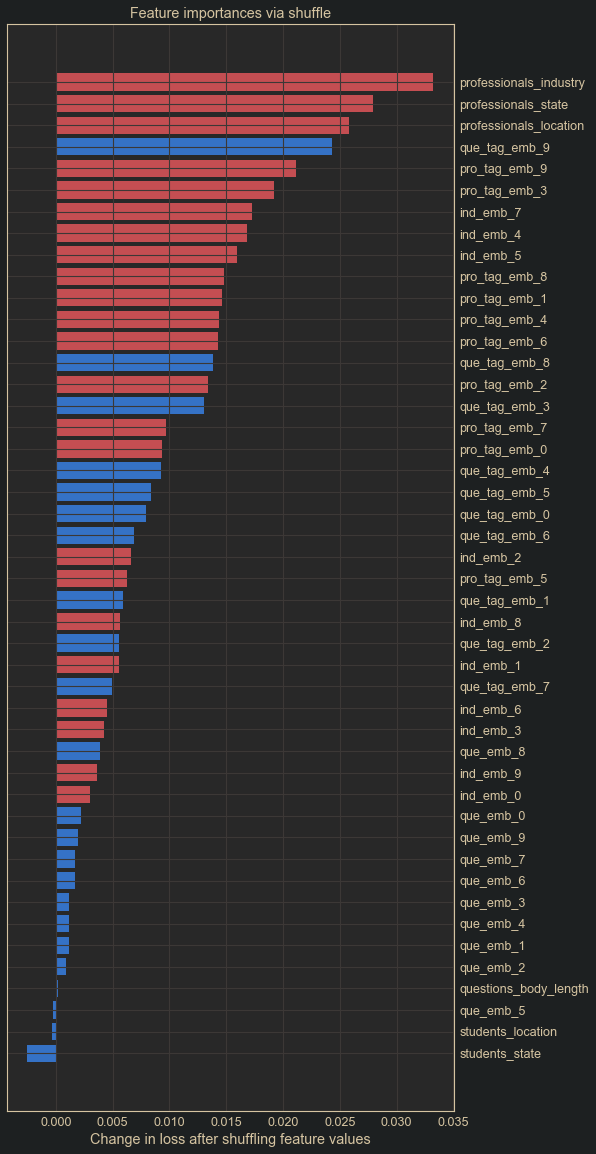

In [63]:
evaluating.plot_fi(fi, fn_content)

In [64]:
fi = evaluating.permutation_importance(
    True, content_model, test_batch_generator[0][0], test_batch_generator[0][1], fn_content, 23, 23)

2048/2048 [==============================] - ETA:  - ETA:  - ETA:  - 0s 68us/step


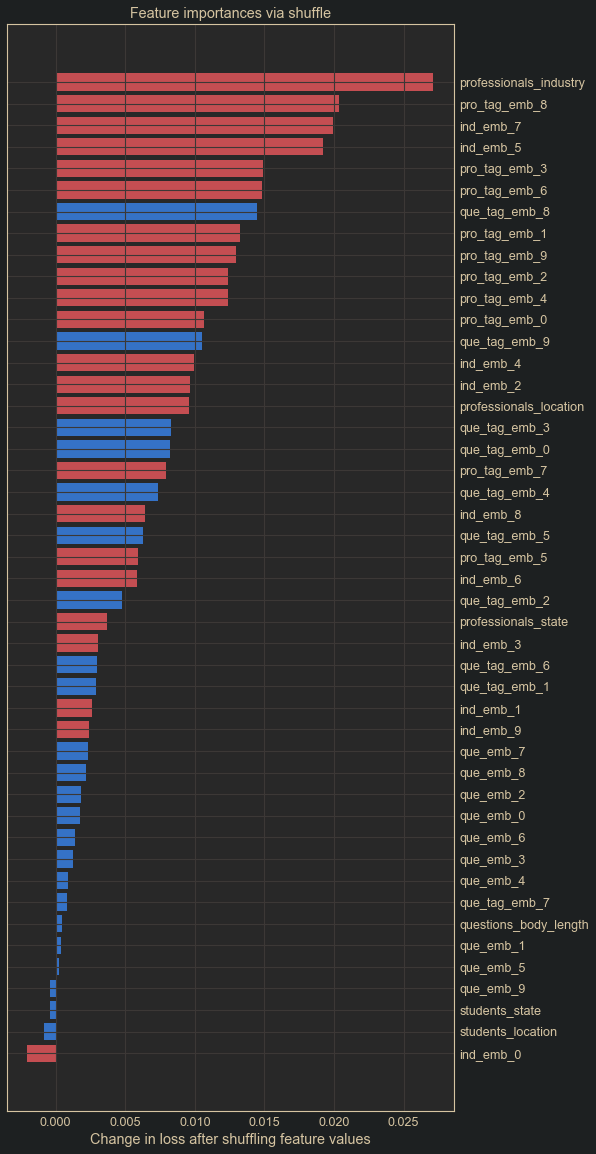

In [65]:
evaluating.plot_fi(fi, fn_content)

### Time model feature importance

In [66]:
fi = evaluating.permutation_importance(
    False, time_model, train_batch_generator[0][0], train_batch_generator[0][1], fn_time, 23, 23)

2048/2048 [==============================] - ETA:  - ETA:  - ETA:  - 0s 58us/step


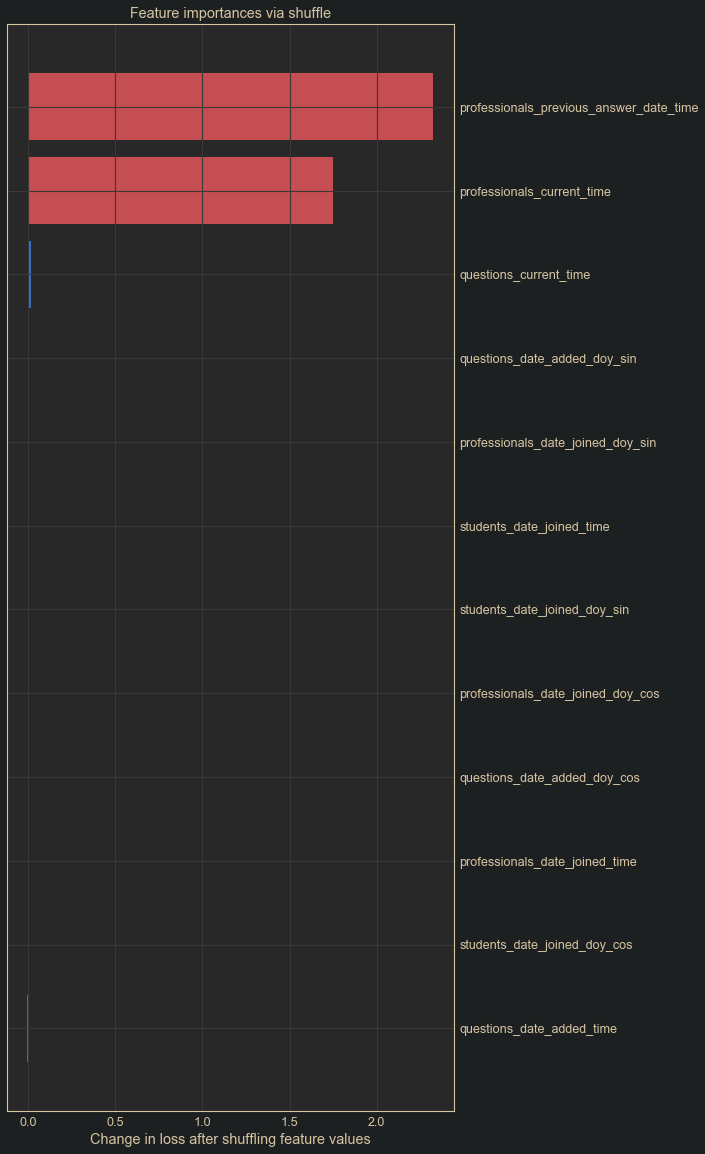

In [67]:
evaluating.plot_fi(fi, fn_time)

In [68]:
fi = evaluating.permutation_importance(
    False, time_model, test_batch_generator[0][0], test_batch_generator[0][1], fn_time, 23, 23)

2048/2048 [==============================] - ETA:  - ETA:  - ETA:  - 0s 58us/step


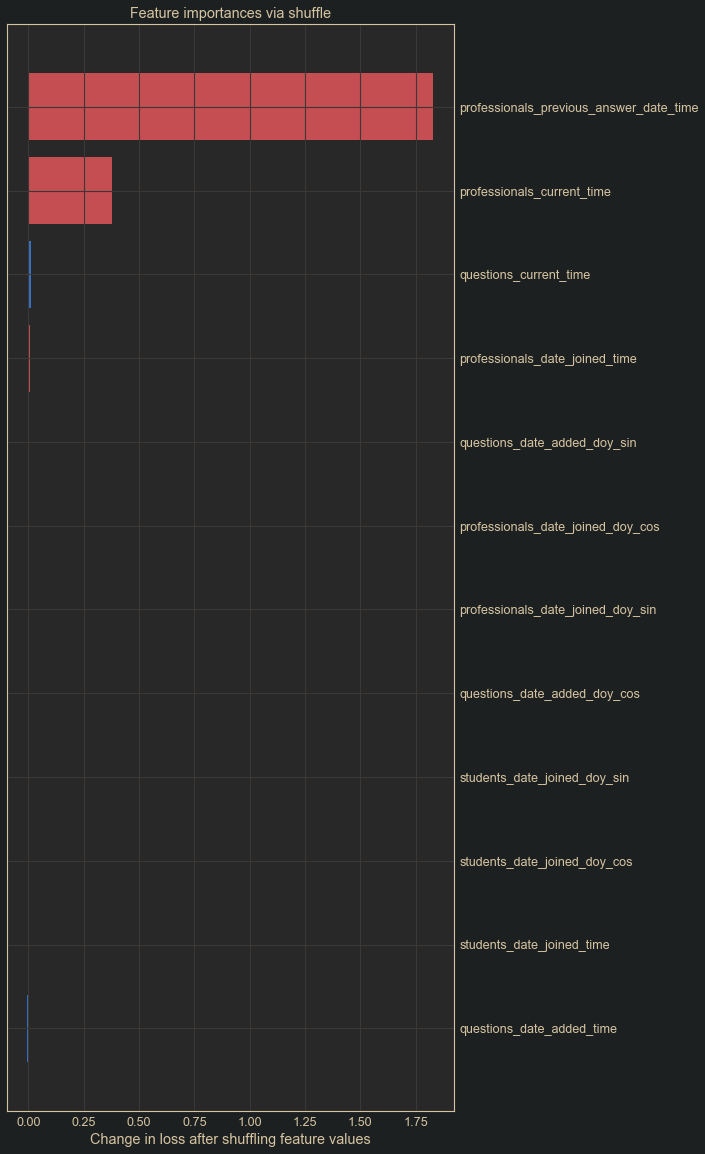

In [69]:
evaluating.plot_fi(fi, fn_time)

---

# Model predictions

In [40]:
import pickle
with open('que_emb_dict.pickle', 'rb') as f:
    que_emb_dict = pickle.load(f)
with open('pro_emb_dict.pickle', 'rb') as f:
    pro_emb_dict = pickle.load(f)

In [42]:
que_emb_dict['332a511f1569444485cf7a7a556a5e54'].shape

(1, 20)

In [44]:
pro_emb_dict['91ae6749fe4b4d3a8d49892fa5e103f4'].shape

(1, 20)

In [45]:
model.predict([que_emb_dict['332a511f1569444485cf7a7a556a5e54'], pro_emb_dict['91ae6749fe4b4d3a8d49892fa5e103f4']])

array([[0.38337797]], dtype=float32)

In [48]:
%%timeit
model.predict([que_emb_dict['332a511f1569444485cf7a7a556a5e54'], pro_emb_dict['91ae6749fe4b4d3a8d49892fa5e103f4']])

685 µs ± 49.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [50]:
unique_que = que_emb_dict.keys()
import random
ques = random.sample(unique_que, 10)

In [51]:
ques

['ee5413617a51437f9d58a3d2f870d89b',
 'cf215635476749c89e3d75cf24532a9c',
 '12874ccefffe4b6fa4226f0792690642',
 'c864355f2a654468aa3d4be79b0ee70c',
 'd08a2430911f44d6917098bbcca412a8',
 '898c7879dc1842bebdcd45a49a76e6fd',
 '1500eea6b157405c802ad008bd232152',
 'db8050a0c7ab4acd9c63b890fd66e5f3',
 '7c9c284e305645fa9e53f524b9cc9381',
 '04000a02ec2b44a9af7f310210921763']

In [54]:
import pandas as pd
que_preds_dict = {}
for que in ques:
    que_emb = que_emb_dict[que]
    preds = []
    for pro, pro_emb in pro_emb_dict.items():
        preds.append((pro, model.predict([que_emb, pro_emb])[0][0]))
    preds = pd.DataFrame.from_records(preds, columns=['pro_id', 'score']).sort_values(by='score')
    best_profs = preds.iloc[-10:, :]
    que_preds_dict[que] = best_profs
    print("Finished:", que)

Finished: ee5413617a51437f9d58a3d2f870d89b
Finished: cf215635476749c89e3d75cf24532a9c
Finished: 12874ccefffe4b6fa4226f0792690642
Finished: c864355f2a654468aa3d4be79b0ee70c
Finished: d08a2430911f44d6917098bbcca412a8
Finished: 898c7879dc1842bebdcd45a49a76e6fd
Finished: 1500eea6b157405c802ad008bd232152
Finished: db8050a0c7ab4acd9c63b890fd66e5f3
Finished: 7c9c284e305645fa9e53f524b9cc9381
Finished: 04000a02ec2b44a9af7f310210921763


In [55]:
que_preds_dict['ee5413617a51437f9d58a3d2f870d89b']

,pro_id,score
649,68dd845397354a808ec9971488190426,0.945925
794,49448856f96843f29c84d95f622a8639,0.947177
40,0c1da6b3b5d441ddb4760a3a5f1246c3,0.954507
8486,d4781dad42b747b0bd036efaa63910d9,0.957144
9853,20cadbf6b1494430b16230de160e2e89,0.959015
9281,fec7fe38089d4d1f92b7262047de6f4f,0.962602
1364,d1134871a74042b69faba3615b0495ab,0.966555
2983,a9c872b6f46f4250b3c01a35c0762dcd,0.966555
7565,793d64b966e648be9b3976f7d31cd3bf,0.966563
1118,d754969c1565445db381bb2d75273ee1,0.967282


In [56]:
with open('que_preds_dict.pkl', 'wb') as f:
    pickle.dump(que_preds_dict, f)

---

# Analyze model mistakes

In [88]:
import numpy as np

In [89]:
predictions = model.predict_generator(test_generator)

In [90]:
preds = np.round(predictions).reshape(-1)
preds

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [91]:
preds.shape

(10368,)

In [92]:
true_block = np.concatenate([np.ones(64), np.zeros(64)])
true = np.tile(true_block, 81)
true.shape

(10368,)

In [93]:
print('Accuracy:', np.mean(preds == true))

Accuracy: 0.7093942901234568


In [94]:
true_positive = preds[(true == 1) & (preds == 1)].shape[0]
pred_positive = preds[preds == 1].shape[0]
precision = true_positive / pred_positive
print('Precision:', precision)

Precision: 0.6904720126337954


In [95]:
true_positive = preds[(true == 1) & (preds == 1)].shape[0]
actual_positive = true[true == 1].shape[0]
recall = true_positive / actual_positive
print('Recall:', recall)

Recall: 0.7590663580246914


---

# Visualize Embedding layer

In [16]:
model.get_layer('embedding_5').get_weights()[0][:5]

array([[-0.16669342, -0.05181905],
       [-0.31278333,  0.45776057],
       [ 0.06563876,  0.6340236 ],
       [-0.29971415, -0.24004257],
       [ 0.21710661,  0.6552507 ]], dtype=float32)

In [17]:
importlib.reload(evaluating)

<module 'evaluating' from 'C:\\Users\\dell\\Notebooks\\cv\\kostya\\evaluating.py'>

In [18]:
import pickle
with open('preprocessors.pickle', 'rb') as f:
    preproc = pickle.load(f)

preproc['professionals_industry'].classes_[:10]

array(['Accounting', 'Airlines/Aviation', 'Animation',
       'Apparel and Fashion', 'Architecture & Planning',
       'Architecture and Planning', 'Automotive', 'Aviation & Aerospace',
       'Aviation and Aerospace', 'Banking'], dtype=object)

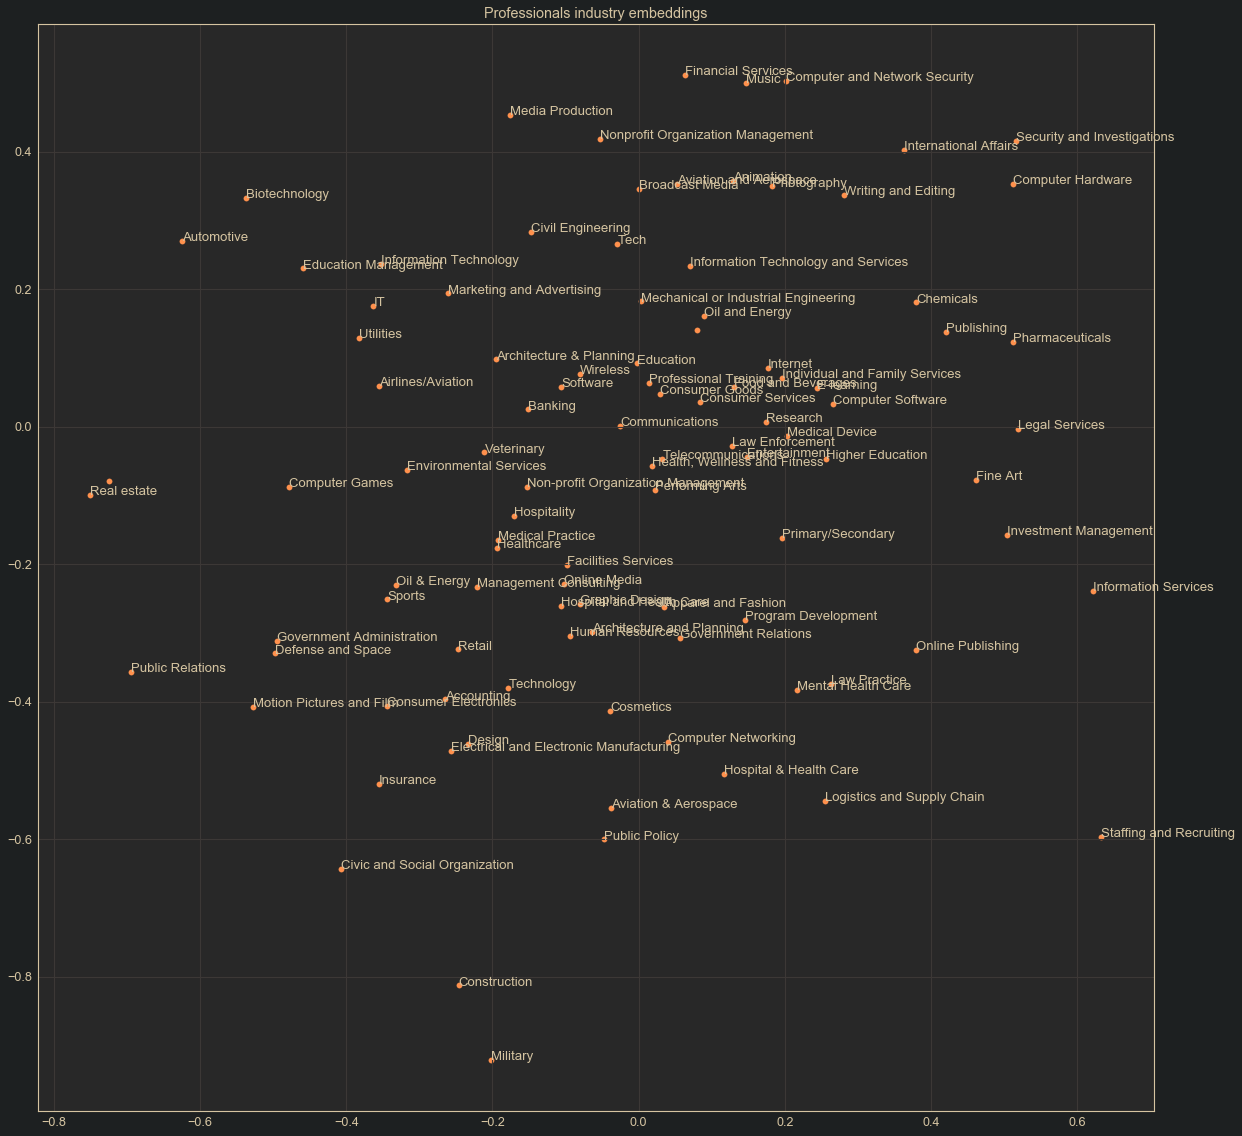

In [112]:
evaluating.vis_emb(model, 'embedding_15', preproc['professionals_industry'].classes_,
                   (20, 20), 'y', 'Professionals industry embeddings')

---